In [1]:
import os
import pandas as pd
import numpy as np
import math
import sys
import shutil
import time


from sklearn.decomposition import PCA
from sklearn import svm
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as plcolors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib notebook

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics.pairwise import rbf_kernel

import joblib

# input path of data to load
# and locations of where to save figures and gridsearch objects
figs_path = ''
grids_path = ''

plt.rcParams["font.family"] = "Times New Roman"

C:\Users\pat99\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\pat99\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\pat99\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def print_size(df):
    '''
        Pass dataframe
        Print the number of rows and if it is Neutron or Gamma
    '''
    
    if df['label'][0] == 0:
        print("There are "+str(df.shape[0])+" gamma pulses.")
    elif df['label'][0] == 1:
        print("There are "+str(df.shape[0])+" neutron pulses.")
    else:
        raise RuntimeError("Error. Could not read label. Labels must be integers 0 or 1.")

In [3]:
def concat_classes(df_list):
    '''
        Takes the dataframe list
        Concatenates the neutrons into one df and gammas in another
        Returns another dataframe list half the size of the one passed
    '''
    
    n_dfs = []
    g_dfs = []
    # split by class
    for df in df_list:
        if df['label'][0] == 0:
            g_dfs.append(df)
            continue
        elif df['label'][0] == 1:
            n_dfs.append(df)
            continue
            
    return [pd.concat(g_dfs, ignore_index=True), pd.concat(n_dfs, ignore_index=True)]

In [4]:
def readin_data(path, get_filenames=False):
    '''
        Supply the directory path to the data
            The data files should be the only thing in the directory
            (i.e. no subdirectories)
        Returns a list of DataFrames for ALL datasets (total and validation)
        
        If get_filenames=True, also returns a list of filenames in the same order
            as the dataframe list
    '''
    
    try:
        sub_dir = [os.path.join(path, d + "/") for d in os.listdir(path)]
        
        # Reads csvs and resets the index
        pulses = []
        fnames = []
        print("Reading files: ")
        for s in sub_dir:
            for f in os.listdir(s):
                print(f)
                fnames.append(f)
                pulses.append(pd.read_csv(os.path.join(s, f)))
        print()
        
#         pulses = [pd.read_csv(os.path.join(path, f))
#                   for f in os.listdir(path)] 
        
        # Print size of data sets
        [print_size(p) for p in pulses]
        
        # Optionally return filenames as list
        if get_filenames:
            return pulses, fnames
        
        return pulses
    except:
        '''
            Raise error if something goes wrong.
            Most likely problem is that the path is wrong
        '''
        raise RuntimeError("Something bad happened in readin_data(). Path supplied=", path)

In [5]:
def split_datasets(pulses, fnames):
    '''
        Pass list of dataframes and list of filenames in the same order
        
        Splits the dataframe list into 2 df lists: All pulses, and those 
        with the ToF cut applied (i.e. validation set)
        
        Return 2 dataframe lists: all pulses, validation pulses
    '''
    
    val = []
    tot = []
    for i in range(len(fnames)):
        # Check last letter of filename
        if fnames[i][-5] == 'n':
            val.append(pulses[i])
        else:
            tot.append(pulses[i])
            
    return tot, val

In [7]:
def format_data_set(df_list, num_features=496):
    '''
        Pass a list of dataframes
        Concatenates them
        Returns numpy matrix of features and a numpy arrray of labels
        
    '''
    
    # concatenate
    data = pd.concat(df_list, ignore_index=True)
    
    
    return data.iloc[:,:num_features].values, data['label'].values

In [8]:
def plot_pca(X, y, n_components=2, save_as=None, heatmap=False):
    '''
        Input data
        Plot as 2 principal components
        
        Heatmap=True for heatmap, optional save_as
        
    '''
    
    
    pca = PCA(n_components=n_components)
    pca.fit(X)
    principal_comp = pca.transform(X)
    
    classes = ['Gamma', 'Neutron']
    xticks = np.arange(min(principal_comp[:,0]), max(principal_comp[:,0]), 0.5)
    yticks = np.arange(min(principal_comp[:,1]), max(principal_comp[:,1]), 0.5)
    

    # Plot all
    fig, ax = plt.subplots(1, figsize=(10, 8))
    scttr = plt.scatter(principal_comp[:,0], principal_comp[:,1], c=y, s=4, alpha=0.6)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(handles=scttr.legend_elements()[0], labels=classes)
    plt.grid()
    
    if save_as:
        plt.savefig(save_as, format='jpg', dpi=300, bbox_inches = 'tight')
    
    plt.show()
        
    
    if heatmap:
        fig, ax = plt.subplots(1, figsize=(10, 8))
        plt.hist2d(principal_comp[:,0], principal_comp[:,1], bins=(150, 150), cmap=cm.jet)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        #plt.savefig(fname, format='jpg', dpi=300, bbox_inches = 'tight')
        plt.show()

In [9]:
# For simplicities sake, only test 1 hyper parameter at a time to use this function

# plots multiple scoring methods from fitted gridsearch (edit some to not be copy)
# grid - fitted gridsearch
# scoring - dictionary of scoring methods
# param - the parameter to be used as the xaxis (must be str)
# units is a string for labeling the annotations - e.g.: 'ns'
# xax_shift is a tuple with 2 values. The first is a multiplier and the second is an intercept
#   It is primarily for when the xaxis is refering to indexes instead of time values
# xax_scale is either 'linear' or 'log'. For tuning C and gamma it is helpful to 
#   have the xaxis as a log base 2
# ymin should be in the range 0-100
# ymax is pretty much the same thing but for practical usage it should be around 100-105
# figsz is a tuple w/ the figure size - default is (12, 12)
# x/y_ann are used to adjust the annotations on each figure (90, 95, 98, best)
# show_ann is pretty self explanatory - only applies to 90, 95, and 98 - not the best one
# to save the figure, enter the filepath+filename.jpg as a string


# idx skip is an ugly method to plot the gridsearch results after multiple parameters are tested (start, end, step)
# set show_best and annotations to False until fixed
def plot_grid_scores(grid, scoring, param, x_label='', y_label='Score', units='', xax_shift=(1, 0),
                     xax_scale='linear', yax_scale=1.0, ymin=0, ymax=100, figsz=(12, 12), show_best=False,
                     x_ann=(0, 0, 0, 0), y_ann=(0, 0, 0, 0), show_ann=(True, True, True), idx_skip=(0,None,1),
                     save_as=None):
    
    results = grid.cv_results_
    
    fig, ax = plt.subplots(1, figsize=figsz)
    ax.set_ylim([ymin*yax_scale,ymax*yax_scale])
                           

    X_axis = np.array(results['param_'+param].data, dtype=float)
    X_axis = (X_axis + xax_shift[1])*xax_shift[0]
    
    if xax_scale=='log':
        ax.set_xscale('log', basex=2)
        
    
    for scorer, color in zip(sorted(scoring), ['g', 'k', 'r', 'b']):
        
        for sample, style, backupcolor in (('train', '-', 'k'), ('test', '-', 'r')):
            
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]*yax_scale
            sample_score_std = results['std_%s_%s' % (sample, scorer)]*yax_scale
            ax.fill_between(X_axis[idx_skip[0]:idx_skip[1]:idx_skip[2]], (sample_score_mean - sample_score_std)[idx_skip[0]:idx_skip[1]:idx_skip[2]], 
                            (sample_score_mean + sample_score_std)[idx_skip[0]:idx_skip[1]:idx_skip[2]],
                            alpha=0.1 if sample == 'test' else 0, 
                            color=color if len(scoring)>1 else backupcolor)
            ax.plot(X_axis[idx_skip[0]:idx_skip[1]:idx_skip[2]], sample_score_mean[idx_skip[0]:idx_skip[1]:idx_skip[2]], style, 
                color=color if len(scoring)>1 else backupcolor,
                alpha=1 if sample == 'test' else 0.8,
                label="%s (%s)" % (scorer, sample))
            ax.scatter(X_axis[idx_skip[0]:idx_skip[1]:idx_skip[2]], sample_score_mean[idx_skip[0]:idx_skip[1]:idx_skip[2]], 
                color=color if len(scoring)>1 else backupcolor)

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        if show_best:
            ax.plot([X_axis[best_index], ] * 2, [0, best_score*yax_scale], 
                    linestyle='-.', color='m', marker='x', markeredgewidth=4, ms=8, alpha=0.5)

            # Annotate the best score for that scorer
            ax.annotate("%d%s - %0.3f%%" % (X_axis[best_index], units, best_score*yax_scale),
                        (X_axis[best_index] + x_ann[3], best_score*yax_scale + y_ann[3]), fontsize=14)
        
        # Show where 90%, 95%, and 98% test accuracy is acheived
        if show_ann[0]:
            ax.plot([X_axis[np.where(sample_score_mean>=(0.9*yax_scale))[0][0]], ] * 2, 
                    [0, sample_score_mean[np.where(sample_score_mean>=(0.9*yax_scale))[0][0]]], 
                    linestyle='-.', color='k', marker='x', markeredgewidth=4, ms=8, alpha=0.5) 
            ax.annotate("%d%s - 90%%" % (X_axis[np.where(sample_score_mean>=(0.9*yax_scale))[0][0]], units), 
                        (X_axis[np.where(sample_score_mean>=(0.9*yax_scale))[0][0]] + x_ann[0], (0.9*yax_scale) + y_ann[0]), fontsize=14)
        if show_ann[1]:
            ax.plot([X_axis[np.where(sample_score_mean>=(0.95*yax_scale))[0][0]], ] * 2, 
                    [0, sample_score_mean[np.where(sample_score_mean>=(0.95*yax_scale))[0][0]]], 
                    linestyle='-.', color='k', marker='x', markeredgewidth=4, ms=8, alpha=0.5) 
            ax.annotate("%d%s - 95%%" % (X_axis[np.where(sample_score_mean>=(0.95*yax_scale))[0][0]], units), 
                        (X_axis[np.where(sample_score_mean>=(0.95*yax_scale))[0][0]] + x_ann[1], (0.95*yax_scale) + y_ann[1]), fontsize=14)
        if show_ann[2]:
            ax.plot([X_axis[np.where(sample_score_mean>=(0.98*yax_scale))[0][0]], ] * 2, 
                    [0, sample_score_mean[np.where(sample_score_mean>=(0.98*yax_scale))[0][0]]], 
                    linestyle='-.', color='k', marker='x', markeredgewidth=4, ms=8, alpha=0.5) 
            ax.annotate("%d%s - 98%%" % (X_axis[np.where(sample_score_mean>=(0.98*yax_scale))[0][0]], units), 
                        (X_axis[np.where(sample_score_mean>=(0.98*yax_scale))[0][0]] + x_ann[2], (0.98*yax_scale) + y_ann[2]), fontsize=14)

    plt.xlabel(x_label, fontsize=24)
    plt.ylabel(y_label, fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.legend(loc="lower right", prop={"size":16}, markerscale=3.5)
    ax.set_axisbelow(True)
    ax.grid()
    
    if save_as:
        plt.savefig(save_as, format='jpg', dpi=300, bbox_inches = 'tight')
    
    plt.show()

In [12]:
'''
    Used to plot the results of a gridsearch for two hyperparameters
    as a 3d plot.
    
    Only plots the mean test accuracy
    TODO:
        - log scale
        - tick sizes
        - saving
        - color bar
        - overlapping scatter
    
    Most parameters are the same as the plot_grid_scores() function
     - 'ax_' parameters will be applied to both of the hyperparameter axes
     - 'zax_' refers to the dependent axis
     - param_dict is a dictionary containing the names of a hyperparameter
     - scoring parameter is a string
     and the label to use when plotting
         - e.g. {'svm__C':'C', 'svm__gamma':'Beta'}
         - Pay close attention to the ordering of hyperparametrs so they match the order used
         by the grid search
     - param_len is a list containing the number of values tested for each hyperparameter
'''

def plot_3d_grid_scores(grid, param_dict, param_len, scoring='Accuracy', zlabel='Accuracy (%)', units='', 
                       ax_shift=(1,0), ax_scale='linear', zax_scale=1.0, zmin=0.0, zmax=100.0, 
                        cmap_=None, save_as=None):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    hyperparams = list(param_dict.keys())
    ax_labels = list(param_dict.values())
    
    X = np.reshape(grid.cv_results_['param_'+hyperparams[0]], param_len)
    Y = np.reshape(grid.cv_results_['param_'+hyperparams[1]], param_len)
    Z = np.reshape((grid.cv_results_['mean_test_'+scoring])*zax_scale, param_len)
    Z2 = np.reshape((grid.cv_results_['mean_train_'+scoring])*zax_scale, param_len)
    
    
#     if ax_scale=='log':
#         pass
    
    # plot
    surf = ax.plot_surface(X, Y, Z, facecolors=cm.jet(Z/np.amax(Z)), linewidth=0, antialiased=False)
    
    
    plt.xlabel(ax_labels[0], fontsize=24)
    plt.ylabel(ax_labels[1], fontsize=24)
    ax.set_zlabel(zlabel, fontsize=24)
#     plt.xticks(fontsize=16)
#     plt.yticks(fontsize=16)
#     plt.zticks(fontsize=16)
    
    ax.set_zlim(zmin, zmax)
    
    #fig.colorbar(surf, shrink=0.3, aspect=5)
    
    if save_as:
        pass
    
    
    plt.show()

In [13]:
def plot_svm(X, y, model, sv_color='#00AFF0', save_as=None):
    '''
        Plot 2d SVM (w/ or w/o kernel trick)
    '''
    #clrs = ['b' if l > 0 else 'r' for l in y]
    
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.scatter(X[:,0], X[:,1], c=y, alpha=0.8, s=8)
    ax.grid()
    
    plot_svm_bounds(model, ax=ax)
    
    # support vectors 
    '''
    models w/ custom kernels cant access 
    actual support vectors only their indicies
    
    sv gets handles this issue
    '''
    sv = X[model.support_]
    print("No. of Support Vectors: "+str(model.support_.shape[0]))
    ax.scatter(sv[:, 0], sv[:, 1], 
        alpha=1, s=40, linewidth=1, 
        edgecolors=sv_color, facecolors='none');
    
    # 0 - '#440154', 1 - '#FDE725'
    # creating legend
    leg_elements = [Line2D([0], [0], color='w', markerfacecolor='#440154', marker='o', markersize=10, label='Gamma'), # Gamma Color - Dark Purple
                   Line2D([0], [0], color='w', markerfacecolor='#FDE725', marker='o', markersize=10, label='Neutron'), # Neutron color - Yellow
                   Line2D([0], [0], color='w', markeredgecolor=sv_color, marker='o', markeredgewidth=1, markersize=11, label='Support Vectors')]
    
    ax.legend(handles=leg_elements, loc='lower right', prop={"size":16}, markerscale=1.5)
    plt.xlabel("Principal Component 1", fontsize=28)
    plt.ylabel("Principal Component 2", fontsize=28)
#     plt.xticks(np.arange(-3, X[:,0].max(), 0.5)) # delete later
#     plt.yticks(np.arange(-2, 3, 0.5)) # delete later


    #plt.xlim([-4, 4])
    #plt.ylim([-4, 4])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    
    
    if save_as:
        '''
            save_as should be passed a string of the full file name (including the path)
        '''
        plt.savefig(save_as, format='jpg', dpi=300, bbox_inches = 'tight')
    
    
    
    

def plot_svm_bounds(model, ax=None):
    '''
        Plot decision boundary and margin lines of SVM in 2 dimensions
    '''
    if ax is None:
        ax = plt.gca()
        
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    

    
    x = np.linspace(xlim[0], xlim[1], 50)
    y = np.linspace(ylim[0], ylim[1], 50)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    
    # plot db and margins
    ax.contour(X, Y, P, colors=['k', 'r', 'k'],
               levels=[-1, 0, 1], alpha=0.7,
               linestyles=['--', '-', '--'])
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

## Readin Data

In [14]:
# split into validation set
# X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=0, test_size=0.2)
# print("Neutron ratio in train set: " + str(y_train.sum() / y_train.shape[0]))
# print("Neutron ratio in validation set: " + str(y_val.sum() / y_val.shape[0]))

## LOAD DATA

pulses, fnames = readin_data(data_path, get_filenames=True)

# separate the datasets
# bad naming. change val to cut
all_pulses, val_pulses = split_datasets(pulses, fnames)

# concatenate sets

print()

# all
pulses_all = concat_classes(all_pulses)
print("In total dataset (no ToF cut):")
[print_size(p) for p in pulses_all]


print()

# validation
pulses_val = concat_classes(val_pulses)
print("In validation dataset (ToF cut):")
[print_size(p) for p in pulses_val]

X, y = format_data_set(pulses_all)
Xv, yv = format_data_set(pulses_val)

# change labels from 0,1 to -1,1
y[y == 0] = -1
yv[yv == 0] = -1

NameError: name 'data_path' is not defined

Split into Tuning and Validation sets (tof cut data and non-tof cut data)

In [10]:
from sklearn.utils import shuffle

def make_train_test_splits(Xuc, yuc, Xc, yc, test_size=0.25):
    '''
        Make train test sets from cut and uncut data
        DONT USE FOR NOW
    '''
    #####
    # Split the cut data
    # The train set will be used for training
    # the test cut will be added to the uncut data
    ####
    
    X_train, Xc_test, y_train, yc_test = train_test_split(Xc, yc, test_size=test_size, random_state=10)
    
    # Combine remaining cut pulses with uncut ones
    Xcomb = np.concatenate((Xuc, Xc_test), axis=0)
    ycomb = np.concatenate((yuc, yc_test), axis=0)
    
    # shuffle the combined test set
    X_test, y_test = shuffle(Xcomb, ycomb, random_state=10)
    
    return X_train, X_test, y_train, y_test


def separate_cut(total, cut_eidx):
    '''
        Takes a dataframe of total pulses and the event indexes of tof cut pulses
        
        Returns dataframe of total pulses minus the ones that pass the tof cut
    '''
    return total[total.event_index.isin(cut_eidx) == False]

def split_cut_uncut(total_pulses, tof_cut):
    '''
        Pass total pulses df list and tof_cut df list.
        
        Return uncut and cut data as nparrays
        
    '''
    
    # new df list for non-cut pulses
    uncut = []
    for total, cut in zip(total_pulses, tof_cut):
        uncut.append(separate_cut(total, cut['event_index']))
    
    
    # concatenate and format the df lists as np arrays
    X_uncut, y_uncut = format_data_set(uncut)
    X_cut, y_cut = format_data_set(tof_cut)
    
    # change labels from 0,1 to -1,1
    y_uncut[y_uncut == 0] = -1
    y_cut[y_cut == 0] = -1
    

    return X_uncut, y_uncut, X_cut, y_cut

In [11]:
# split data into cut and uncut
# val_pulses are the tof cut pulses. In reality these will be used for tuning and the non-cut will be used for validation
X_uncut, y_uncut, X_cut, y_cut = split_cut_uncut(all_pulses, val_pulses)
print("TOF cut pulses: " +str(X_cut.shape))
print("Non TOF cut pulses: " + str(X_uncut.shape))

TOF cut pulses: (8290, 496)
Non TOF cut pulses: (15488, 496)


Find ratio of variance explained by n components

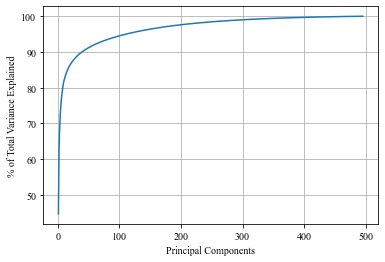

In [12]:
max_comps = 495
pca = PCA(n_components=max_comps)
pca.fit(stats.zscore(X_cut, axis=1, ddof=1))


# Variance explained by first n components
plt.plot(range(1, max_comps+1), np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('Principal Components')
plt.ylabel('% of Total Variance Explained')
plt.grid()
#plt.savefig(figs_path+"var_explained_ncomps.jpg", format='jpg', dpi=300, bbox_inches = 'tight')

### Testing Setup

Functions and Transformers

In [13]:
# stats.z-score
class zscore_scale(BaseEstimator, TransformerMixin):
    # constructor
    def __init__(self):
        # do noting
#         print("Scaling...")
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # copy to new memory loc for safety 
        X_ = X.copy()
        return stats.zscore(X_, axis=1, ddof=1)
    
class cut_waveform(BaseEstimator, TransformerMixin):
    # constructor, initialize with start and end index
    def __init__(self, step=1, start_idx=0, n_dimensions=496):
        self.step = step
        self.n_dimensions = n_dimensions
        self.start_idx = start_idx
        
    def fit(self, X, y=None):
        #print(X.shape)
        return self
    
    def transform(self, X, y=None):
        # copy to new memory loc
        end = min((self.step*self.n_dimensions + self.start_idx), 496)
        X_ = X.copy()
        X_ = X_[:, self.start_idx:end:self.step]
        
        print("New Shape: "+str(X_.shape))
        return X_
    
    
    
    
# Absolute exponential kernel (special case of Matern where nu=0.5)
# Use 'precomputed' for the kernel for this case 

class AbsExpKernel(BaseEstimator,TransformerMixin):
    def __init__(self, gamma='auto'):
        super(AbsExpKernel,self).__init__()
        self.gamma = gamma

    def transform(self, X):
        X_ = X.copy()
        return Matern(length_scale=(1.0/self.gamma), nu=0.5).__call__(X_, self.X_train_)

    def fit(self, X, y=None, **fit_params):
        self.X_train_ = X.copy()
        
        # if gamma = auto. Set gamma = 1/ (# features)
        if self.gamma == 'auto':
            self.gamma = 1.0 / self.X_train_.shape[1]
        
        return self

Params, Pipes, and Grids

In [14]:
## Constant values
num_pcs = 300
num_dims = 496
# path extension to different subdirectories
path_ext = ''

In [15]:
# parameter grids for pca 

param_grid_p_lin = {
    'pca__n_components': np.arange(2, 300, 8),
#     'svm__C': np.array([2**i for i in range(-7, 8)]),
}

param_grid_p_rbf = {
    'pca__n_components': np.arange(2, 300, 8),
#     'svm__gamma': np.array([2**i for i in range(-10, 4)]),
#     'svm__C': np.array([2**i for i in range(-7, 8)]),
}

param_grid_p_exp = {
    'pca__n_components': np.arange(2, 300, 8),
#     'abs_exp__gamma': np.array([2**i for i in range(-10, 4)]),
#     'svm__C': np.array([2**i for i in range(-7, 8)]),
}

# parameter grids for waveform cuts
param_grid_w_lin = {
     'time__n_dimensions': np.arange(0, 500, 16),
#     'svm__C': np.array([2**i for i in range(-7, 8)]),
}

param_grid_w_rbf = {
     'time__n_dimensions': np.arange(0, 500, 16),
#     'svm__gamma': np.array([2**i for i in range(-10, 4)]),
#     'svm__C': np.array([2**i for i in range(-7, 8)]),
}

param_grid_w_exp = {
     'time__n_dimensions': np.arange(0, 500, 16),
#     'abs_exp__gamma': np.array([2**i for i in range(-10, 4)]),
#     'svm__C': np.array([2**i for i in range(-7, 8)]),
}

##########################################

# Pipelines for pca
pipe_lin_p = Pipeline(steps=[('scaler', zscore_scale()),
                      ('pca', PCA()),
                      ('svm', svm.SVC(kernel='linear', C=1))])


pipe_rbf_p = Pipeline(steps=[('scaler', zscore_scale()),
                      ('pca', PCA()),
                      ('svm', svm.SVC(kernel='rbf', C=128, gamma=0.0078125))])


pipe_exp_p = Pipeline(steps=[('scaler', zscore_scale()),
                      ('pca', PCA()),
                      ('abs_exp', AbsExpKernel(gamma=0.015625)),
                      ('svm', svm.SVC(kernel='precomputed', C=128))])



# Pipelines for waveform cuts
# z-score AFTER waveform cuts
pipe_lin_w = Pipeline(steps=[('time', cut_waveform()), 
                      ('scaler', zscore_scale()),
                      ('svm', svm.SVC(kernel='linear', C=0.5))])

pipe_rbf_w = Pipeline(steps=[('time', cut_waveform()), 
                      ('scaler', zscore_scale()),
                      ('svm', svm.SVC(kernel='rbf', C=64, gamma=0.015625))])

pipe_exp_w = Pipeline(steps=[('time', cut_waveform()), 
                      ('scaler', zscore_scale()),
                      ('abs_exp', AbsExpKernel(gamma=0.015625)),
                      ('svm', svm.SVC(kernel='precomputed', C=128))])


In [16]:
# Cross-Validation generator
# This way each grid will process the same dataset splits

kcv = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)


# scoring
scorer = {'Accuracy': 'accuracy'}

# Grids
grid_lin_p = GridSearchCV(pipe_lin_p, param_grid_p_lin, scoring=scorer, refit='Accuracy', cv=kcv, n_jobs=-1, return_train_score=True)
grid_rbf_p = GridSearchCV(pipe_rbf_p, param_grid_p_rbf, scoring=scorer, refit='Accuracy', cv=kcv, n_jobs=-1, return_train_score=True)
grid_exp_p = GridSearchCV(pipe_exp_p, param_grid_p_exp, scoring=scorer, refit='Accuracy', cv=kcv, n_jobs=-1, return_train_score=True)

grid_lin_w = GridSearchCV(pipe_lin_w, param_grid_w_lin, scoring=scorer, refit='Accuracy', cv=kcv, n_jobs=-1, return_train_score=True)
grid_rbf_w = GridSearchCV(pipe_rbf_w, param_grid_w_rbf, scoring=scorer, refit='Accuracy', cv=kcv, n_jobs=-1, return_train_score=True)
grid_exp_w = GridSearchCV(pipe_exp_w, param_grid_w_exp, scoring=scorer, refit='Accuracy', cv=kcv, n_jobs=-1, return_train_score=True)

# Save the Grid along with a name to save
grid_dict = {
    'grid_lin_pca' : grid_lin_p, 
    'grid_rbf_pca' : grid_rbf_p, 
    'grid_exp_pca' : grid_exp_p, 
    
    'grid_lin_wave' : grid_lin_w, 
    'grid_rbf_wave' : grid_rbf_w, 
    'grid_exp_wave' : grid_exp_w,
    
}

## Run and Print no. iterations

In [17]:
# Evaluate
for name, grid in grid_dict.items():
    
    print("Fitting "+name)
    
    curr_time = time.time()
    grid.fit(X_cut, y_cut)
    print(str((time.time() - curr_time)/60)+" minutes")
    
    print(grid.best_params_)
    print(grid.best_score_)

    
    # save grid
    print("Saving "+name)
    joblib.dump(grid, grids_path+path_ext+name+".pkl")
    
    print("Done with "+name)
    print("\n--------------------------\n")

Fitting grid_lin_pca
2.1512819369633993 minutes
{'pca__n_components': 290}
0.9711700844390831
Saving grid_lin_pca
Done with grid_lin_pca

--------------------------

Fitting grid_rbf_pca
2.040007833639781 minutes
{'pca__n_components': 146}
0.9768395657418576
Saving grid_rbf_pca
Done with grid_rbf_pca

--------------------------

Fitting grid_exp_pca
17.530062027772267 minutes
{'pca__n_components': 290}
0.9753920386007238
Saving grid_exp_pca
Done with grid_exp_pca

--------------------------

Fitting grid_lin_wave
New Shape: (8290, 496)
1.972459908326467 minutes
{'time__n_dimensions': 496}
0.9699638118214716
Saving grid_lin_wave
Done with grid_lin_wave

--------------------------

Fitting grid_rbf_wave
New Shape: (8290, 496)
1.913637630144755 minutes
{'time__n_dimensions': 496}
0.9745476477683956
Saving grid_rbf_wave
Done with grid_rbf_wave

--------------------------

Fitting grid_exp_wave
New Shape: (8290, 464)
22.4949111700058 minutes
{'time__n_dimensions': 464}
0.9759951749095295
Sa

### Plot Hyperparameter Grids
Plot by Hyperparameters and Features

##### PCA

Linear

In [17]:
# another subdirectory path extension
param_ext = ""

In [18]:
grid_lin_p = joblib.load(grids_path+path_ext+"grid_lin_pca.pkl")
print(grid_lin_p.best_params_)
print(grid_lin_p.best_score_)
# print(grid_lin_p.cv_results_)

{'pca__n_components': 290}
0.9711700844390831


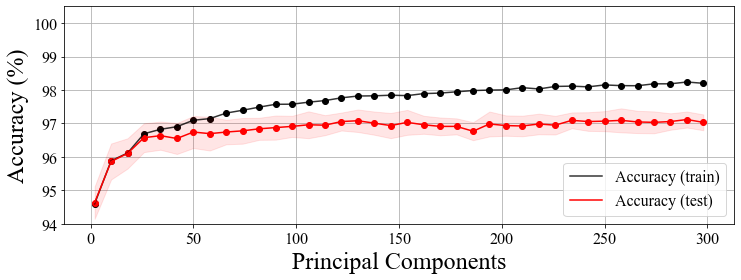

In [19]:
plot_grid_scores(grid_lin_p, {'Accuracy':'accuracy'}, param='pca__n_components', x_label='Principal Components', 
                 y_label='Accuracy (%)', ymin=0.94, ymax=1.005, units='', figsz=(12, 4), 
                 xax_shift=(1,0), xax_scale='linear', yax_scale=100, show_best=False, 
                 x_ann=(0, 18, 10, 1), y_ann=(0, -.8, -1.2, -1), show_ann=(False, False, False),
                 idx_skip=(0,None,1), save_as=None)

# save location
# figs_path+path_ext+"grid_lin_pca.jpg"

In [20]:
grid_lin_p2 = joblib.load(grids_path+param_ext+"grid_lin_pca.pkl")
print(grid_lin_p2.best_params_)
print(grid_lin_p2.best_score_)
#print(grid_lin_p2.cv_results_['params'])

{'svm__C': 1.0}
0.9702050663449939
[{'svm__C': 0.0078125}, {'svm__C': 0.015625}, {'svm__C': 0.03125}, {'svm__C': 0.0625}, {'svm__C': 0.125}, {'svm__C': 0.25}, {'svm__C': 0.5}, {'svm__C': 1.0}, {'svm__C': 2.0}, {'svm__C': 4.0}, {'svm__C': 8.0}, {'svm__C': 16.0}, {'svm__C': 32.0}, {'svm__C': 64.0}, {'svm__C': 128.0}]


C:\Users\pat99\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.decomposition.pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\pat99\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator PCA from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\pat99\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Any

C:\Users\pat99\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


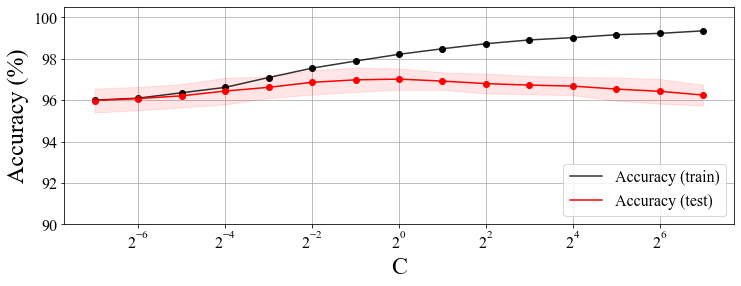

In [72]:
plot_grid_scores(grid_lin_p2, {'Accuracy':'accuracy'}, param='svm__C', x_label='C', 
                 y_label='Accuracy (%)', ymin=0.90, ymax=1.005, units='', figsz=(12, 4), 
                 xax_shift=(1,0), xax_scale='log', yax_scale=100, show_best=False, 
                 x_ann=(0, 18, 10, 1), y_ann=(0, -.8, -1.2, -1), show_ann=(False, False, False),
                 idx_skip=(0,None,1), save_as=None)

RBF

In [229]:
grid_rbf_p = joblib.load(grids_path+path_ext+"grid_rbf_pca.pkl")
print(grid_rbf_p.best_params_)
print(grid_rbf_p.best_score_)
#print(grid_rbf_p.cv_results_['mean_test_Accuracy'])

{'pca__n_components': 146}
0.9768395657418576
[0.94595899 0.95826297 0.96188179 0.96803378 0.96863691 0.97165259
 0.97237636 0.97285887 0.97394451 0.97370326 0.973462   0.97430639
 0.97370326 0.97454765 0.97503016 0.97490953 0.97599517 0.97490953
 0.97683957 0.97623643 0.9761158  0.97587455 0.97527141 0.97539204
 0.97454765 0.97587455 0.97563329 0.97539204 0.97503016 0.9747889
 0.97490953 0.97454765 0.97394451 0.97394451 0.97322075 0.97490953
 0.97466828 0.97430639]


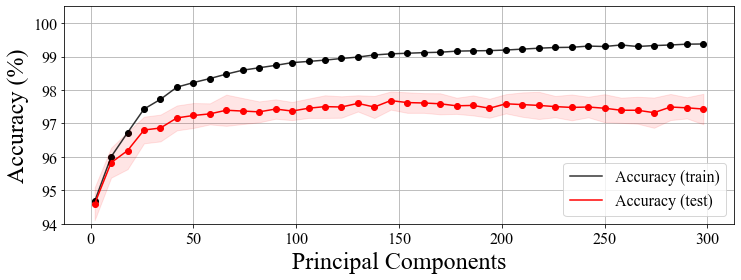

In [23]:
plot_grid_scores(grid_rbf_p, {'Accuracy':'accuracy'}, param='pca__n_components', x_label='Principal Components', 
                 y_label='Accuracy (%)', ymin=0.94, ymax=1.005, units='', figsz=(12, 4), 
                 xax_shift=(1,0), xax_scale='linear', yax_scale=100, show_best=False, 
                 x_ann=(0, 18, 10, 1), y_ann=(0, -.8, -1.2, -1), show_ann=(False, False, False),
                 idx_skip=(0,None,1), save_as=None)

# figs_path+path_ext+"grid_rbf_pca.jpg"

In [225]:
grid_rbf_p2 = joblib.load(grids_path+param_ext+"grid_rbf_pca.pkl")
print(grid_rbf_p2.best_params_)
print(grid_rbf_p2.best_score_)
# print(grid_rbf_p2.cv_results_['params'][3::14])
# print()
# print(grid_rbf_p2.cv_results_['params'][196:210])
# print(grid_rbf_p2.cv_results_['mean_test_Accuracy'][196:210])

{'svm__C': 128.0, 'svm__gamma': 0.0078125}
0.9752714113389626
[{'svm__C': 0.0078125, 'svm__gamma': 0.0078125}, {'svm__C': 0.015625, 'svm__gamma': 0.0078125}, {'svm__C': 0.03125, 'svm__gamma': 0.0078125}, {'svm__C': 0.0625, 'svm__gamma': 0.0078125}, {'svm__C': 0.125, 'svm__gamma': 0.0078125}, {'svm__C': 0.25, 'svm__gamma': 0.0078125}, {'svm__C': 0.5, 'svm__gamma': 0.0078125}, {'svm__C': 1.0, 'svm__gamma': 0.0078125}, {'svm__C': 2.0, 'svm__gamma': 0.0078125}, {'svm__C': 4.0, 'svm__gamma': 0.0078125}, {'svm__C': 8.0, 'svm__gamma': 0.0078125}, {'svm__C': 16.0, 'svm__gamma': 0.0078125}, {'svm__C': 32.0, 'svm__gamma': 0.0078125}, {'svm__C': 64.0, 'svm__gamma': 0.0078125}, {'svm__C': 128.0, 'svm__gamma': 0.0078125}]

[{'svm__C': 128.0, 'svm__gamma': 0.0009765625}, {'svm__C': 128.0, 'svm__gamma': 0.001953125}, {'svm__C': 128.0, 'svm__gamma': 0.00390625}, {'svm__C': 128.0, 'svm__gamma': 0.0078125}, {'svm__C': 128.0, 'svm__gamma': 0.015625}, {'svm__C': 128.0, 'svm__gamma': 0.03125}, {'svm__C': 1

C:\Users\pat99\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


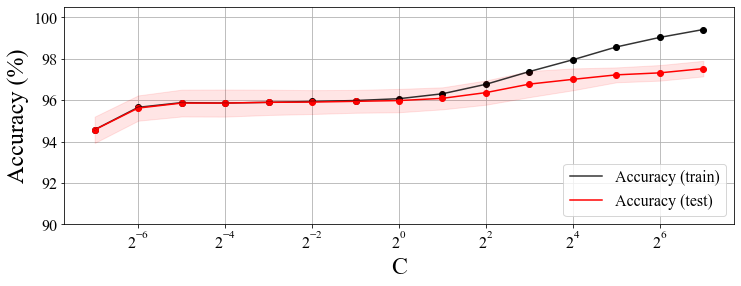

In [74]:
plot_grid_scores(grid_rbf_p2, {'Accuracy':'accuracy'}, param='svm__C', x_label='C', 
                 y_label='Accuracy (%)', ymin=0.90, ymax=1.005, units='', figsz=(12, 4), 
                 xax_shift=(1,0), xax_scale='log', yax_scale=100, show_best=False, 
                 x_ann=(0, 18, 10, 1), y_ann=(0, -.8, -1.2, -1), show_ann=(False, False, False),
                 idx_skip=(3,None,14), save_as=None)

# gamma = 0.0078125

C:\Users\pat99\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


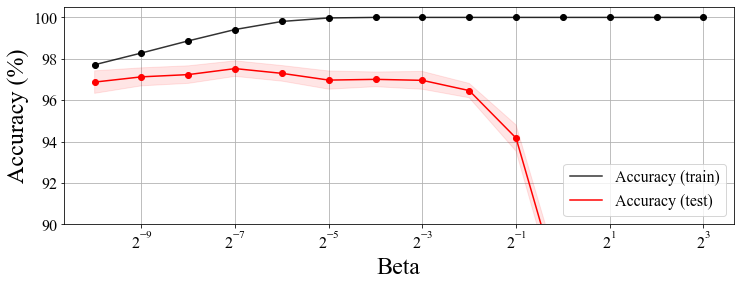

In [76]:
plot_grid_scores(grid_rbf_p2, {'Accuracy':'accuracy'}, param='svm__gamma', x_label='Beta', 
                 y_label='Accuracy (%)', ymin=0.90, ymax=1.005, units='', figsz=(12, 4), 
                 xax_shift=(1,0), xax_scale='log', yax_scale=100, show_best=False, 
                 x_ann=(0, 18, 10, 1), y_ann=(0, -.8, -1.2, -1), show_ann=(False, False, False),
                 idx_skip=(196,210,1), save_as=None)

# C = 128

Exponential

In [27]:
grid_exp_p = joblib.load(grids_path+path_ext+"grid_exp_pca.pkl")
print(grid_exp_p.best_params_)
print(grid_exp_p.best_score_)
# print(grid_exp_p.cv_results_['mean_test_Accuracy'])
# print(grid_exp_p.cv_results_['mean_train_Accuracy'])

{'pca__n_components': 290}
0.9753920386007238
[0.94499397 0.95633293 0.96405308 0.96960193 0.97117008 0.97189385
 0.97165259 0.97261761 0.97285887 0.97382388 0.97406514 0.9747889
 0.97430639 0.9747889  0.97454765 0.97527141 0.97418577 0.97490953
 0.97466828 0.97418577 0.97454765 0.97442702 0.97442702 0.97442702
 0.97454765 0.97442702 0.97466828 0.97466828 0.97466828 0.9747889
 0.97466828 0.97466828 0.97503016 0.97515078 0.97490953 0.97503016
 0.97539204 0.97503016]
[0.95126659 0.99707479 0.99981906 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


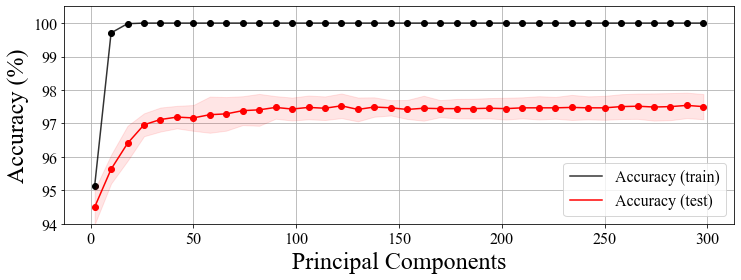

In [28]:
plot_grid_scores(grid_exp_p, {'Accuracy':'accuracy'}, param='pca__n_components', x_label='Principal Components', 
                 y_label='Accuracy (%)', ymin=0.94, ymax=1.005, units='', figsz=(12, 4), 
                 xax_shift=(1,0), xax_scale='linear', yax_scale=100, show_best=False, 
                 x_ann=(0, 18, 10, 1), y_ann=(0, -.8, -1.2, -1), show_ann=(False, False, False),
                 idx_skip=(0,None,1), save_as=None)

# figs_path+path_ext+"grid_exp_pca.jpg"

In [228]:
grid_exp_p2 = joblib.load(grids_path+param_ext+"grid_exp_pca.pkl")
print(grid_exp_p2.best_params_)
print(grid_exp_p2.best_score_)
# print(grid_exp_p2.cv_results_['params'][14::15])
# print()
# print(grid_exp_p2.cv_results_['params'][60:75])
# print(grid_exp_p2.cv_results_['mean_test_Accuracy'][14::15])

{'abs_exp__gamma': 0.015625, 'svm__C': 128.0}
0.9749095295536792
[{'abs_exp__gamma': 0.0009765625, 'svm__C': 128.0}, {'abs_exp__gamma': 0.001953125, 'svm__C': 128.0}, {'abs_exp__gamma': 0.00390625, 'svm__C': 128.0}, {'abs_exp__gamma': 0.0078125, 'svm__C': 128.0}, {'abs_exp__gamma': 0.015625, 'svm__C': 128.0}, {'abs_exp__gamma': 0.03125, 'svm__C': 128.0}, {'abs_exp__gamma': 0.0625, 'svm__C': 128.0}, {'abs_exp__gamma': 0.125, 'svm__C': 128.0}, {'abs_exp__gamma': 0.25, 'svm__C': 128.0}, {'abs_exp__gamma': 0.5, 'svm__C': 128.0}, {'abs_exp__gamma': 1.0, 'svm__C': 128.0}, {'abs_exp__gamma': 2.0, 'svm__C': 128.0}, {'abs_exp__gamma': 4.0, 'svm__C': 128.0}, {'abs_exp__gamma': 8.0, 'svm__C': 128.0}]

[{'abs_exp__gamma': 0.015625, 'svm__C': 0.0078125}, {'abs_exp__gamma': 0.015625, 'svm__C': 0.015625}, {'abs_exp__gamma': 0.015625, 'svm__C': 0.03125}, {'abs_exp__gamma': 0.015625, 'svm__C': 0.0625}, {'abs_exp__gamma': 0.015625, 'svm__C': 0.125}, {'abs_exp__gamma': 0.015625, 'svm__C': 0.25}, {'abs_ex

C:\Users\pat99\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


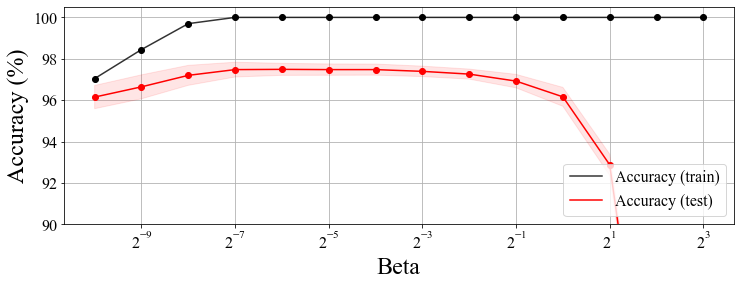

In [78]:
plot_grid_scores(grid_exp_p2, {'Accuracy':'accuracy'}, param='abs_exp__gamma', x_label='Beta', 
                 y_label='Accuracy (%)', ymin=0.9, ymax=1.005, units='', figsz=(12, 4), 
                 xax_shift=(1,0), xax_scale='log', yax_scale=100, show_best=False, 
                 x_ann=(0, 18, 10, 1), y_ann=(0, -.8, -1.2, -1), show_ann=(False, False, False),
                 idx_skip=(14,None,15), save_as=None)

# C = 128

C:\Users\pat99\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


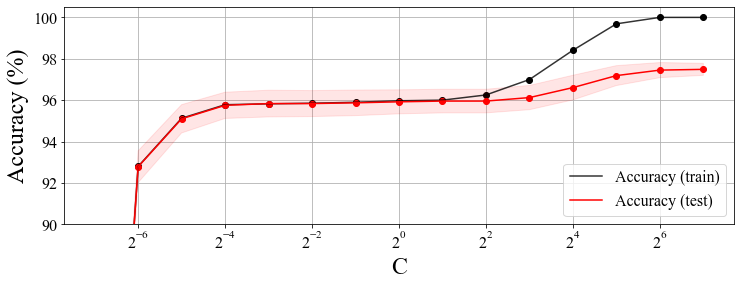

In [80]:
plot_grid_scores(grid_exp_p2, {'Accuracy':'accuracy'}, param='svm__C', x_label='C', 
                 y_label='Accuracy (%)', ymin=0.90, ymax=1.005, units='', figsz=(12, 4), 
                 xax_shift=(1,0), xax_scale='log', yax_scale=100, show_best=False, 
                 x_ann=(0, 18, 10, 1), y_ann=(0, -.8, -1.2, -1), show_ann=(False, False, False),
                 idx_skip=(60,75,1), save_as=None)

# gamma = 0.015625

##### Waveform Length

Linear

In [32]:
grid_lin_w = joblib.load(grids_path+path_ext+"grid_lin_wave.pkl")
print(grid_lin_w.best_params_)
print(grid_lin_w.best_score_)
# print(grid_lin_w.cv_results_['mean_test_Accuracy'])

{'time__n_dimensions': 496}
0.9699638118214716
[       nan        nan 0.70566948 0.95452352 0.96079614 0.96236429
 0.96308806 0.96320869 0.96332931 0.96344994 0.96357057 0.96369119
 0.96308806 0.96369119 0.96369119 0.9641737  0.96598311 0.96718938
 0.96658625 0.96718938 0.9681544  0.96791315 0.96875754 0.9681544
 0.96803378 0.9681544  0.96851628 0.96875754 0.96972256 0.9694813
 0.96936068 0.96996381]


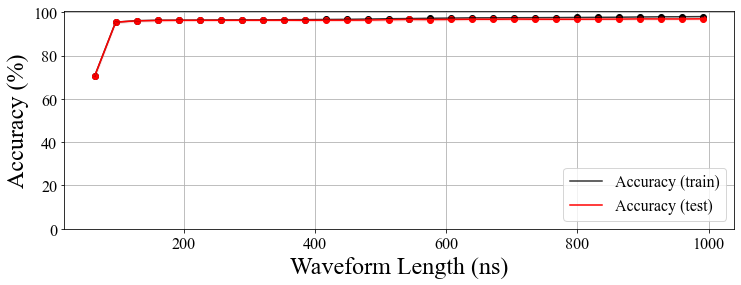

In [33]:
plot_grid_scores(grid_lin_w, {'Accuracy':'accuracy'}, param='time__n_dimensions', x_label='Waveform Length (ns)', 
                 y_label='Accuracy (%)', ymin=0.94, ymax=1.005, units='ns', figsz=(12, 4), 
                 xax_shift=(2,0), xax_scale='linear', yax_scale=100, show_best=False, 
                 x_ann=(0, 18, 10, 1), y_ann=(0, -.8, -1.2, -1), show_ann=(False, False, False),
                 idx_skip=(0,None,1), save_as=None)

# figs_path+path_ext+"grid_lin_wave.jpg"

In [34]:
grid_lin_w2 = joblib.load(grids_path+param_ext+"grid_lin_wave.pkl")
print(grid_lin_w2.best_params_)
print(grid_lin_w2.best_score_)
# print(grid_lin_w2.cv_results_['params'])

{'svm__C': 0.5}
0.9703256936067551
[{'svm__C': 0.0078125}, {'svm__C': 0.015625}, {'svm__C': 0.03125}, {'svm__C': 0.0625}, {'svm__C': 0.125}, {'svm__C': 0.25}, {'svm__C': 0.5}, {'svm__C': 1.0}, {'svm__C': 2.0}, {'svm__C': 4.0}, {'svm__C': 8.0}, {'svm__C': 16.0}, {'svm__C': 32.0}, {'svm__C': 64.0}, {'svm__C': 128.0}]


C:\Users\pat99\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator SVC from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\pat99\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Pipeline from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\pat99\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


C:\Users\pat99\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


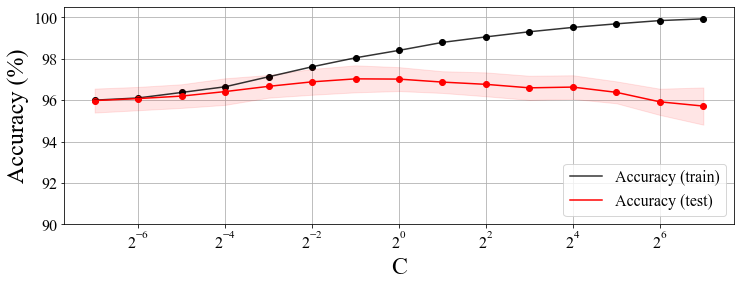

In [82]:
plot_grid_scores(grid_lin_w2, {'Accuracy':'accuracy'}, param='svm__C', x_label='C', 
                 y_label='Accuracy (%)', ymin=0.90, ymax=1.005, units='', figsz=(12, 4), 
                 xax_shift=(1,0), xax_scale='log', yax_scale=100, show_best=False, 
                 x_ann=(0, 18, 10, 1), y_ann=(0, -.8, -1.2, -1), show_ann=(False, False, False),
                 idx_skip=(0,None,1), save_as=None)

RBF

In [218]:
grid_rbf_w = joblib.load(grids_path+path_ext+"grid_rbf_wave.pkl")
print(grid_rbf_w.best_params_)
print(grid_rbf_w.best_score_)
# print(grid_rbf_w.cv_results_['mean_test_Accuracy'])

{'time__n_dimensions': 496}
0.9745476477683956
[       nan        nan 0.70277443 0.95476478 0.96067551 0.9641737
 0.96525935 0.96501809 0.96622437 0.96755127 0.96827503 0.96960193
 0.96936068 0.96960193 0.9694813  0.97129071 0.97261761 0.97285887
 0.97370326 0.97322075 0.97442702 0.97334138 0.97358263 0.97189385
 0.97249698 0.97273824 0.97285887 0.97225573 0.973462   0.97418577
 0.97322075 0.97454765]


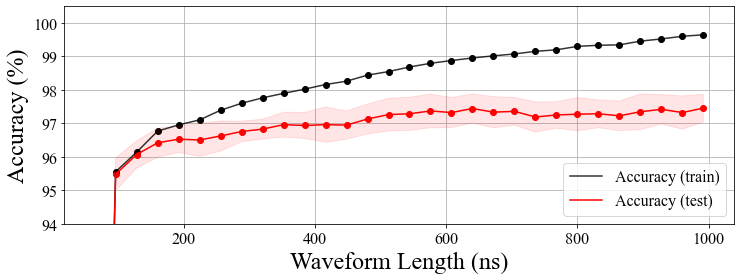

In [83]:
plot_grid_scores(grid_rbf_w, {'Accuracy':'accuracy'}, param='time__n_dimensions', x_label='Waveform Length (ns)', 
                 y_label='Accuracy (%)', ymin=0.94, ymax=1.005, units='ns', figsz=(12, 4), 
                 xax_shift=(2,0), xax_scale='linear', yax_scale=100, show_best=False, 
                 x_ann=(0, 18, 10, 1), y_ann=(0, -.8, -1.2, -1), show_ann=(False, False, False),
                 idx_skip=(0,None,1), save_as=None)

# figs_path+path_ext+"grid_rbf_wave.jpg"

In [38]:
grid_rbf_w2 = joblib.load(grids_path+param_ext+"grid_rbf_wave.pkl")
print(grid_rbf_w2.best_params_)
print(grid_rbf_w2.best_score_)

{'svm__C': 64.0, 'svm__gamma': 0.015625}
0.9743063932448733


C:\Users\pat99\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator SVC from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\pat99\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Pipeline from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\pat99\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


[{'svm__C': 0.0078125, 'svm__gamma': 0.015625}, {'svm__C': 0.015625, 'svm__gamma': 0.015625}, {'svm__C': 0.03125, 'svm__gamma': 0.015625}, {'svm__C': 0.0625, 'svm__gamma': 0.015625}, {'svm__C': 0.125, 'svm__gamma': 0.015625}, {'svm__C': 0.25, 'svm__gamma': 0.015625}, {'svm__C': 0.5, 'svm__gamma': 0.015625}, {'svm__C': 1.0, 'svm__gamma': 0.015625}, {'svm__C': 2.0, 'svm__gamma': 0.015625}, {'svm__C': 4.0, 'svm__gamma': 0.015625}, {'svm__C': 8.0, 'svm__gamma': 0.015625}, {'svm__C': 16.0, 'svm__gamma': 0.015625}, {'svm__C': 32.0, 'svm__gamma': 0.015625}, {'svm__C': 64.0, 'svm__gamma': 0.015625}, {'svm__C': 128.0, 'svm__gamma': 0.015625}]


C:\Users\pat99\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


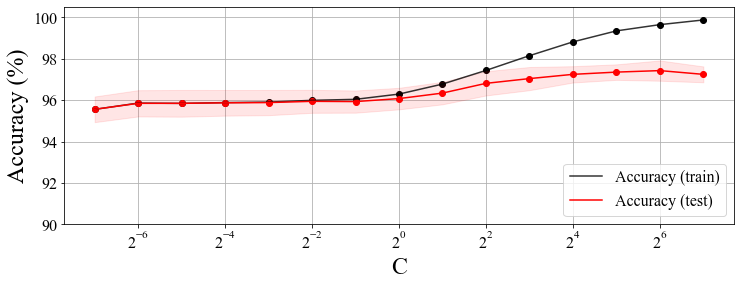

In [85]:
# print(grid_rbf_w2.cv_results_['params'][4::14])

plot_grid_scores(grid_rbf_w2, {'Accuracy':'accuracy'}, param='svm__C', x_label='C', 
                 y_label='Accuracy (%)', ymin=0.90, ymax=1.005, units='', figsz=(12, 4), 
                 xax_shift=(1,0), xax_scale='log', yax_scale=100, show_best=False, 
                 x_ann=(0, 18, 10, 1), y_ann=(0, -.8, -1.2, -1), show_ann=(False, False, False),
                 idx_skip=(4,None,14), save_as=None)

# gamma = 0.015625

[{'svm__C': 64.0, 'svm__gamma': 0.0009765625}, {'svm__C': 64.0, 'svm__gamma': 0.001953125}, {'svm__C': 64.0, 'svm__gamma': 0.00390625}, {'svm__C': 64.0, 'svm__gamma': 0.0078125}, {'svm__C': 64.0, 'svm__gamma': 0.015625}, {'svm__C': 64.0, 'svm__gamma': 0.03125}, {'svm__C': 64.0, 'svm__gamma': 0.0625}, {'svm__C': 64.0, 'svm__gamma': 0.125}, {'svm__C': 64.0, 'svm__gamma': 0.25}, {'svm__C': 64.0, 'svm__gamma': 0.5}, {'svm__C': 64.0, 'svm__gamma': 1.0}, {'svm__C': 64.0, 'svm__gamma': 2.0}, {'svm__C': 64.0, 'svm__gamma': 4.0}, {'svm__C': 64.0, 'svm__gamma': 8.0}]


C:\Users\pat99\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


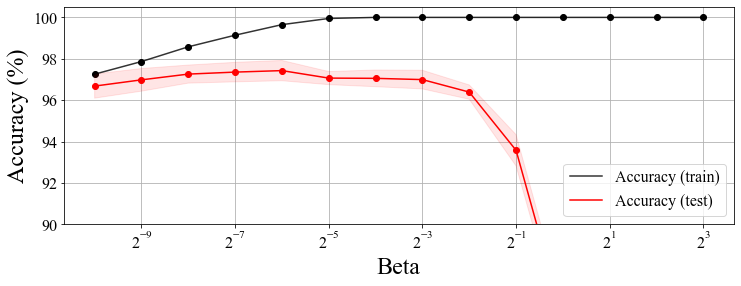

In [87]:
# print(grid_rbf_w2.cv_results_['params'][182:196])
plot_grid_scores(grid_rbf_w2, {'Accuracy':'accuracy'}, param='svm__gamma', x_label='Beta', 
                 y_label='Accuracy (%)', ymin=0.90, ymax=1.005, units='', figsz=(12, 4), 
                 xax_shift=(1,0), xax_scale='log', yax_scale=100, show_best=False, 
                 x_ann=(0, 18, 10, 1), y_ann=(0, -.8, -1.2, -1), show_ann=(False, False, False),
                 idx_skip=(182,196,1), save_as=None)

# C = 64

Exponential

In [41]:
grid_exp_w = joblib.load(grids_path+path_ext+"grid_exp_wave.pkl")
print(grid_exp_w.best_params_)
print(grid_exp_w.best_score_)
# print(grid_exp_w.cv_results_['mean_test_Accuracy'])

{'time__n_dimensions': 464}
0.9759951749095295
[0.50024125        nan 0.69505428 0.95404101 0.96260555 0.96646562
 0.96767189 0.96779252 0.96863691 0.96839566 0.96887817 0.96960193
 0.97032569 0.97044632 0.97008444 0.97020507 0.97044632 0.97056695
 0.97261761 0.97322075 0.97430639 0.97430639 0.97406514 0.97382388
 0.973462   0.97394451 0.97430639 0.97515078 0.97575392 0.97599517
 0.9747889  0.97490953]


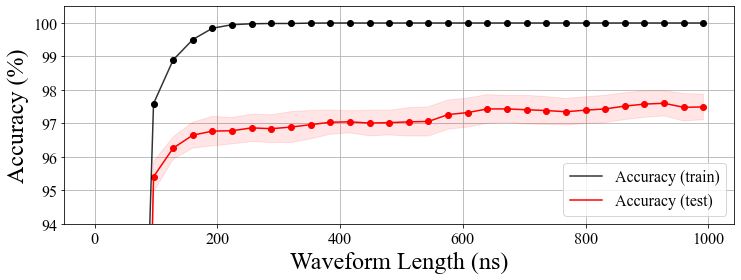

In [222]:
plot_grid_scores(grid_exp_w, {'Accuracy':'accuracy'}, param='time__n_dimensions', x_label='Waveform Length (ns)', 
                 y_label='Accuracy (%)', ymin=0.94, ymax=1.005, units='ns', figsz=(12, 4), 
                 xax_shift=(2,0), xax_scale='linear', yax_scale=100, show_best=False, 
                 x_ann=(0, 18, 10, 1), y_ann=(0, -.8, -1.2, -1), show_ann=(False, False, False),
                 idx_skip=(0,None,1), save_as=None)

# figs_path+path_ext+"grid_exp_wave.jpg"

In [214]:
grid_exp_w2 = joblib.load(grids_path+param_ext+"grid_exp_wave.pkl")
print(grid_exp_w2.best_params_)
print(grid_exp_w2.best_score_)
# print(grid_exp_w2.cv_results_['mean_test_Accuracy'])
# print(grid_exp_w2.cv_results_['params'][60:75])
# print()
# print(grid_exp_w2.cv_results_['params'][14::15])

C:\Users\pat99\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator SVC from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\pat99\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Pipeline from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\pat99\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


{'abs_exp__gamma': 0.015625, 'svm__C': 128.0}
0.9746682750301568
[0.50024125 0.50024125 0.50024125 0.50024125 0.67466828 0.93088058
 0.95186972 0.95790109 0.95838359 0.95838359 0.9588661  0.95910736
 0.95971049 0.95971049 0.96139928 0.50024125 0.50024125 0.50024125
 0.66972256 0.93027744 0.95186972 0.95778046 0.95838359 0.95838359
 0.9588661  0.95922799 0.95971049 0.95958987 0.96139928 0.96622437
 0.50024125 0.50024125 0.66212304 0.92955368 0.95150784 0.95765983
 0.95838359 0.95838359 0.9588661  0.95922799 0.95971049 0.95958987
 0.96139928 0.96598311 0.97225573 0.50024125 0.6477684  0.92882992
 0.95114596 0.95765983 0.95838359 0.95838359 0.9588661  0.95922799
 0.95971049 0.95958987 0.96127865 0.96598311 0.97201448 0.97418577
 0.61809409 0.92762364 0.95114596 0.9575392  0.95838359 0.95838359
 0.95874548 0.95922799 0.95958987 0.95958987 0.96127865 0.96598311
 0.97177322 0.97430639 0.97466828 0.92436671 0.94981906 0.95681544
 0.95814234 0.95838359 0.95874548 0.95922799 0.95958987 0.959469

C:\Users\pat99\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


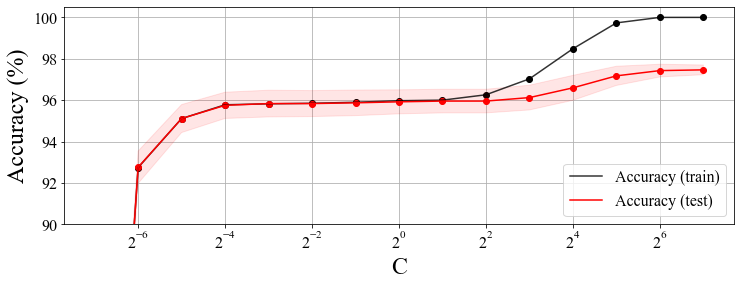

In [89]:
plot_grid_scores(grid_exp_w2, {'Accuracy':'accuracy'}, param='svm__C', x_label='C', 
                 y_label='Accuracy (%)', ymin=0.90, ymax=1.005, units='', figsz=(12, 4), 
                 xax_shift=(1,0), xax_scale='log', yax_scale=100, show_best=False, 
                 x_ann=(0, 18, 10, 1), y_ann=(0, -.8, -1.2, -1), show_ann=(False, False, False),
                 idx_skip=(60,75,1), save_as=None)

# gamma = 0.015625

C:\Users\pat99\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


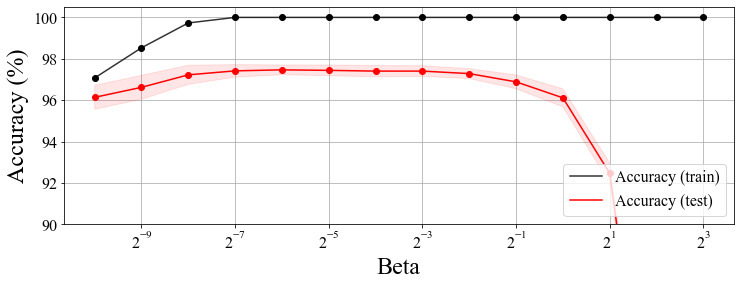

In [91]:
plot_grid_scores(grid_exp_w2, {'Accuracy':'accuracy'}, param='abs_exp__gamma', x_label='Beta', 
                 y_label='Accuracy (%)', ymin=0.90, ymax=1.005, units='', figsz=(12, 4), 
                 xax_shift=(1,0), xax_scale='log', yax_scale=100, show_best=False, 
                 x_ann=(0, 18, 10, 1), y_ann=(0, -.8, -1.2, -1), show_ann=(False, False, False),
                 idx_skip=(14,None,15), save_as=None)
# C = 128

### Validate with Uncut data

In [46]:
## Shuffle uncut
X_val, y_val = shuffle(X_uncut, y_uncut, random_state=10)

In [95]:
grid_lin_p = joblib.load(grids_path+path_ext+"grid_lin_pca.pkl")
print(grid_lin_p.best_params_)
print(grid_lin_p.best_estimator_)

# Transform and predict
y_pred_lin_p = grid_lin_p.best_estimator_.predict(X_val)

{'pca__n_components': 290}
Pipeline(steps=[('scaler', zscore_scale()), ('pca', PCA(n_components=290)),
                ('svm', SVC(C=1, kernel='linear'))])


In [96]:
print(classification_report(y_val, y_pred_lin_p))
print(accuracy_score(y_val, y_pred_lin_p))
print(confusion_matrix(y_val, y_pred_lin_p))

              precision    recall  f1-score   support

          -1       0.98      0.97      0.97      7742
           1       0.97      0.98      0.97      7746

    accuracy                           0.97     15488
   macro avg       0.97      0.97      0.97     15488
weighted avg       0.97      0.97      0.97     15488

0.9737215909090909
[[7525  217]
 [ 190 7556]]


In [97]:
grid_rbf_p = joblib.load(grids_path+path_ext+"grid_rbf_pca.pkl")
print(grid_rbf_p.best_params_)
print(grid_rbf_p.best_estimator_)

# Transform and predict
y_pred_rbf_p = grid_rbf_p.predict(X_val)

{'pca__n_components': 146}
Pipeline(steps=[('scaler', zscore_scale()), ('pca', PCA(n_components=146)),
                ('svm', SVC(C=128, gamma=0.0078125))])


In [98]:
print(classification_report(y_val, y_pred_rbf_p))
print(accuracy_score(y_val, y_pred_rbf_p))
print(confusion_matrix(y_val, y_pred_rbf_p))

              precision    recall  f1-score   support

          -1       0.98      0.98      0.98      7742
           1       0.98      0.98      0.98      7746

    accuracy                           0.98     15488
   macro avg       0.98      0.98      0.98     15488
weighted avg       0.98      0.98      0.98     15488

0.9787577479338843
[[7566  176]
 [ 153 7593]]


In [99]:
grid_exp_p = joblib.load(grids_path+path_ext+"grid_exp_pca.pkl")
print(grid_exp_p.best_params_)
print(grid_exp_p.best_estimator_)

# Transform and predict
y_pred_exp_p = grid_exp_p.predict(X_val)

{'pca__n_components': 290}
Pipeline(steps=[('scaler', zscore_scale()), ('pca', PCA(n_components=290)),
                ('abs_exp', AbsExpKernel(gamma=0.015625)),
                ('svm', SVC(C=128, kernel='precomputed'))])


In [100]:
print(classification_report(y_val, y_pred_exp_p))
print(accuracy_score(y_val, y_pred_exp_p))
print(confusion_matrix(y_val, y_pred_exp_p))

              precision    recall  f1-score   support

          -1       0.98      0.98      0.98      7742
           1       0.98      0.98      0.98      7746

    accuracy                           0.98     15488
   macro avg       0.98      0.98      0.98     15488
weighted avg       0.98      0.98      0.98     15488

0.9775955578512396
[[7575  167]
 [ 180 7566]]


In [101]:
grid_lin_w = joblib.load(grids_path+path_ext+"grid_lin_wave.pkl")
print(grid_lin_w.best_params_)
print(grid_lin_w.best_estimator_)

# Transform and predict
y_pred_lin_w = grid_lin_w.predict(X_val)

{'time__n_dimensions': 496}
Pipeline(steps=[('time', cut_waveform()), ('scaler', zscore_scale()),
                ('svm', SVC(C=0.5, kernel='linear'))])
New Shape: (15488, 496)


In [102]:
print(classification_report(y_val, y_pred_lin_w))
print(accuracy_score(y_val, y_pred_lin_w))
print(confusion_matrix(y_val, y_pred_lin_w))

              precision    recall  f1-score   support

          -1       0.98      0.97      0.97      7742
           1       0.97      0.98      0.97      7746

    accuracy                           0.97     15488
   macro avg       0.97      0.97      0.97     15488
weighted avg       0.97      0.97      0.97     15488

0.9730759297520661
[[7508  234]
 [ 183 7563]]


In [103]:
grid_rbf_w = joblib.load(grids_path+path_ext+"grid_rbf_wave.pkl")
print(grid_rbf_w.best_params_)
print(grid_rbf_w.best_estimator_)

# Transform and predict
y_pred_rbf_w = grid_rbf_w.predict(X_val)

{'time__n_dimensions': 496}
Pipeline(steps=[('time', cut_waveform()), ('scaler', zscore_scale()),
                ('svm', SVC(C=64, gamma=0.015625))])
New Shape: (15488, 496)


In [104]:
print(classification_report(y_val, y_pred_rbf_w))
print(accuracy_score(y_val, y_pred_rbf_w))
print(confusion_matrix(y_val, y_pred_rbf_w))

              precision    recall  f1-score   support

          -1       0.98      0.98      0.98      7742
           1       0.98      0.98      0.98      7746

    accuracy                           0.98     15488
   macro avg       0.98      0.98      0.98     15488
weighted avg       0.98      0.98      0.98     15488

0.976691632231405
[[7563  179]
 [ 182 7564]]


In [105]:
grid_exp_w = joblib.load(grids_path+path_ext+"grid_exp_wave.pkl")
print(grid_exp_w.best_params_)
print(grid_exp_w.best_estimator_)

# Transform and predict
y_pred_exp_w = grid_exp_w.predict(X_val)

{'time__n_dimensions': 464}
Pipeline(steps=[('time', cut_waveform(n_dimensions=464)),
                ('scaler', zscore_scale()),
                ('abs_exp', AbsExpKernel(gamma=0.015625)),
                ('svm', SVC(C=128, kernel='precomputed'))])
New Shape: (15488, 464)


In [109]:
print(classification_report(y_val, y_pred_exp_w))
print(accuracy_score(y_val, y_pred_exp_w))
print(confusion_matrix(y_val, y_pred_exp_w))

              precision    recall  f1-score   support

          -1       0.98      0.98      0.98      7742
           1       0.98      0.98      0.98      7746

    accuracy                           0.98     15488
   macro avg       0.98      0.98      0.98     15488
weighted avg       0.98      0.98      0.98     15488

0.9772081611570248
[[7570  172]
 [ 181 7565]]
